In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

%matplotlib inline

In [2]:
from qiskit_braket_provider import to_braket, BraketProvider
from qiskit_nature.second_q.operators import FermionicOp
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.units import DistanceUnit
from qiskit.quantum_info import Statevector
from qiskit_nature.second_q.mappers.fermionic_mapper import FermionicMapper
from statistics import mean, variance
from utility import Execution

from braket.aws import AwsDevice, DirectReservation
from braket.devices import Devices
from braket.error_mitigation import Debias


hamiltonian: FermionicOp = (
    PySCFDriver(
        atom="H 0 0 0; H 0 0 0.735",
        basis="sto3g",
        charge=0,
        spin=0,
        unit=DistanceUnit.ANGSTROM,
    )
    .run()
    .hamiltonian.second_q_op()
)

# fill in your own reserve arn
RESERVE_ARN = "arn:aws:braket:us-east-1:849837135378:reservation/699fdc53-b71f-43ea-b855-5ab407f3bd5e"


device = AwsDevice(Devices.IonQ.Forte1)
reservation = DirectReservation(device, reservation_arn=RESERVE_ARN).start()

backend = BraketProvider().get_backend("Forte 1")

In [3]:
def process(data: dict[str, int], mapper: FermionicMapper, hamiltonian):
    hamiltonian = mapper.map(hamiltonian)

    energies = []

    for state, n in data.items():
        initial_state = Statevector.from_label(state[::-1])
        exp_energy = initial_state.expectation_value(hamiltonian)  # type: ignore

        for _ in range(n):
            energies.append(exp_energy.real)

    return (
        mean(energies),
        variance(energies),
    )


def run_on_braket(hamiltonian: FermionicOp, mapper: FermionicMapper):
    simulation = Execution(hamiltonian, mapper)
    simulation.circuit.global_phase = 0
    task = backend.run(simulation.circuit, shots=1500, device_parameters={"errorMitigation": Debias()})
    return task, mapper, hamiltonian  # type: ignore

In [4]:
tasks = []

# Jordan-Wigner

In [5]:
from qiskit_nature.second_q.mappers import JordanWignerMapper

tasks.append(run_on_braket(hamiltonian, JordanWignerMapper()))

Hamiltonian simulation:
  Solve ground state:
    Ground energy = -1.857275030202377
  Construct and transpile Pauli evolution:
    Time duration    = 1.0
    Basis gates      = cx, u3
    Synthesis method = LieTrotter
  Circuit summary:
    Depth = 89
    Gates = 57 U3, 50 CX, 4 MEASURE


In [6]:
tasks

[(<qiskit_braket_provider.providers.braket_quantum_task.BraketQuantumTask at 0x7f6ad9acabc0>,
  FermionicOp({'+_0 +_0 -_0 -_0': 0.33785507740175813, '+_0 +_1 -_1 -_0': 0.3322908651276482, '+_0 +_2 -_2 -_0': 0.33785507740175813, '+_0 +_3 -_3 -_0': 0.3322908651276482, '+_0 +_0 -_1 -_1': 0.09046559989211572, '+_0 +_1 -_0 -_1': 0.09046559989211572, '+_0 +_2 -_3 -_1': 0.09046559989211572, '+_0 +_3 -_2 -_1': 0.09046559989211572, '+_1 +_0 -_1 -_0': 0.09046559989211572, '+_1 +_1 -_0 -_0': 0.09046559989211572, '+_1 +_2 -_3 -_0': 0.09046559989211572, '+_1 +_3 -_2 -_0': 0.09046559989211572, '+_1 +_0 -_0 -_1': 0.3322908651276482, '+_1 +_1 -_1 -_1': 0.34928686136600884, '+_1 +_2 -_2 -_1': 0.3322908651276482, '+_1 +_3 -_3 -_1': 0.34928686136600884, '+_2 +_0 -_0 -_2': 0.33785507740175813, '+_2 +_1 -_1 -_2': 0.3322908651276482, '+_2 +_2 -_2 -_2': 0.33785507740175813, '+_2 +_3 -_3 -_2': 0.3322908651276482, '+_2 +_0 -_1 -_3': 0.09046559989211572, '+_2 +_1 -_0 -_3': 0.09046559989211572, '+_2 +_2 -_3 -_3'

# Bravyi-Kitaev

In [7]:
from qiskit_nature.second_q.mappers import BravyiKitaevMapper

tasks.append(run_on_braket(hamiltonian, BravyiKitaevMapper()))

Hamiltonian simulation:
  Solve ground state:
    Ground energy = -1.857275030202382
  Construct and transpile Pauli evolution:
    Time duration    = 1.0
    Basis gates      = cx, u3
    Synthesis method = LieTrotter
  Circuit summary:
    Depth = 88
    Gates = 52 CX, 48 U3, 4 MEASURE


# Balanced Ternary Tree

In [8]:
from ternary_tree_mapper import TernaryTreeMapper

tasks.append(run_on_braket(hamiltonian, TernaryTreeMapper(pair=True)))

Hamiltonian simulation:
  Solve ground state:
    Ground energy = -1.8572750302023757
  Construct and transpile Pauli evolution:
    Time duration    = 1.0
    Basis gates      = cx, u3
    Synthesis method = LieTrotter
  Circuit summary:
    Depth = 88
    Gates = 55 U3, 50 CX, 4 MEASURE


# Fermihedral

In [9]:
from utility import FermihedralMapper

tasks.append(run_on_braket(hamiltonian, FermihedralMapper.molecule()))

Hamiltonian simulation:
  Solve ground state:
    Ground energy = -1.8572750302023757
  Construct and transpile Pauli evolution:
    Time duration    = 1.0
    Basis gates      = cx, u3
    Synthesis method = LieTrotter
  Circuit summary:
    Depth = 77
    Gates = 45 U3, 45 CX, 4 MEASURE


# Our Method

In [10]:
from ternary_bonsai_mapper import HamiltonianTernaryBonsaiMapper

tasks.append(run_on_braket(hamiltonian, HamiltonianTernaryBonsaiMapper(hamiltonian)))

Hamiltonian simulation:
  Solve ground state:
    Ground energy = -1.8572750302023784
  Construct and transpile Pauli evolution:
    Time duration    = 1.0
    Basis gates      = cx, u3
    Synthesis method = LieTrotter
  Circuit summary:
    Depth = 78
    Gates = 57 U3, 42 CX, 4 MEASURE


# Plot

In [1]:
from qiskit_nature.second_q.mappers.fermionic_mapper import FermionicMapper
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.operators import FermionicOp
from braket.aws.aws_quantum_task import AwsQuantumTask
from qiskit.quantum_info import Statevector
from statistics import mean, variance

def process(job : AwsQuantumTask, mapper: FermionicMapper, hamiltonian):
    data = job._download_result().measurement_counts # type: ignore

    hamiltonian = mapper.map(hamiltonian)

    energies = []

    for state, n in data.items():
        initial_state = Statevector.from_label(state[::-1])
        exp_energy = initial_state.expectation_value(hamiltonian)  # type: ignore

        for _ in range(n):
            energies.append(exp_energy.real)

    return (
        mean(energies),
        variance(energies),
    )

hamiltonian: FermionicOp = (
    PySCFDriver(
        atom="H 0 0 0; H 0 0 0.735",
        basis="sto3g",
        charge=0,
        spin=0,
        unit=DistanceUnit.ANGSTROM,
    )
    .run()
    .hamiltonian.second_q_op()
)

In [2]:
from braket.aws.aws_quantum_task import AwsQuantumTask
from qiskit_nature.second_q.mappers import JordanWignerMapper, BravyiKitaevMapper
from ternary_bonsai_mapper import HamiltonianTernaryBonsaiMapper
from ternary_tree_mapper import TernaryTreeMapper
from utility import FermihedralMapper

jwtask = AwsQuantumTask("arn:aws:braket:us-east-1:849837135378:quantum-task/af4dc72c-3546-4ed3-abe9-fda167e9aecb")
bktask = AwsQuantumTask("arn:aws:braket:us-east-1:849837135378:quantum-task/bd373783-52a9-4000-8b29-0b2ed08abb33")
btttask = AwsQuantumTask("arn:aws:braket:us-east-1:849837135378:quantum-task/577a7833-ac65-4145-b2d2-a2a0b1f873eb")
fhtask = AwsQuantumTask("arn:aws:braket:us-east-1:849837135378:quantum-task/f4b13f36-5583-472f-a19e-e2c922db6eb7")
hatttask = AwsQuantumTask("arn:aws:braket:us-east-1:849837135378:quantum-task/efe8ff7b-1f4e-45ed-a126-dfce20d0407d")

tasks = [(jwtask, JordanWignerMapper()), (bktask, BravyiKitaevMapper()), (btttask, TernaryTreeMapper(pair=True)), (fhtask, FermihedralMapper.molecule()), (hatttask, HamiltonianTernaryBonsaiMapper(hamiltonian))]

Task is in terminal state CANCELLED and no result is available.
Task is in terminal state CANCELLED and no result is available.
Task is in terminal state CANCELLED and no result is available.


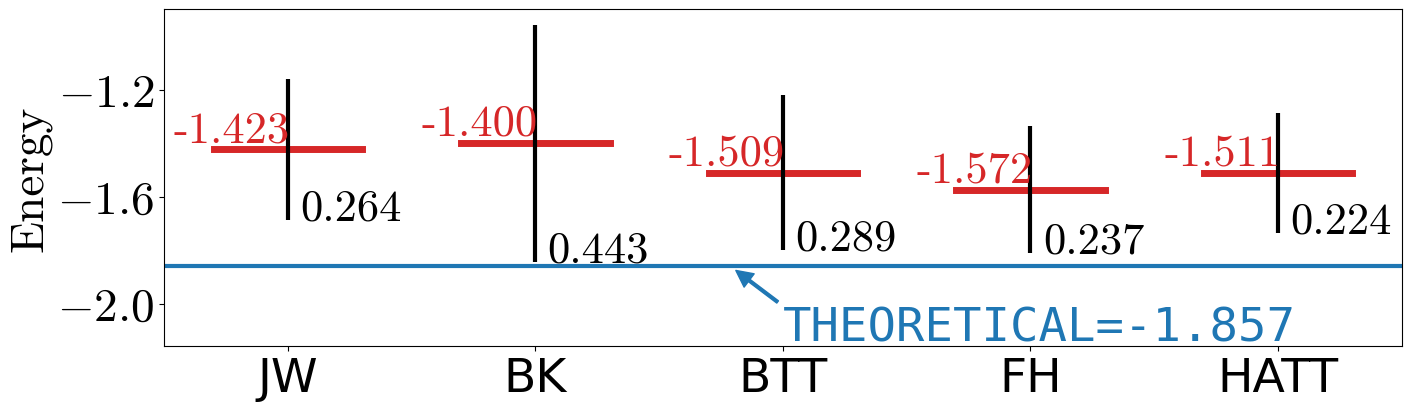

In [11]:
import matplotlib.pyplot as plt

plt.rc("font", size=34, family="serif", serif="cmr10")
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['mathtext.fontset'] = 'cm'

THEO = -1.857275030202381


plt.figure(figsize=(14, 4), layout="constrained")
for n, (mapper, (t, m)) in enumerate(zip(("JW", "BK", "BTT", "FH", "HATT"), tasks)):
    exp, var = process(t, m, hamiltonian)
    plt.plot([n - 0.3, n + 0.3], [exp, exp], color="C3", linewidth=5)
    plt.text(n - 0.46, exp + 0.03, f"{exp:.3f}", color="C3", fontsize=32)
    plt.errorbar(n, exp, var, color="black", linewidth=3)
    plt.text(n + 0.05, exp - var, f"{var:.3f}", fontsize=32)

plt.xlim(0 - 0.5, 4 + 0.5)
plt.ylim(THEO - 0.3, -0.9)
plt.yticks([-2.0, -1.6, -1.2])
plt.ylabel("Energy")
plt.xticks([0, 1, 2, 3, 4], ["JW", "BK", "BTT", "FH", "HATT"], fontfamily="sans serif")

plt.plot([-1, 5], [THEO, THEO], linewidth=3)
plt.annotate(f"THEORETICAL={THEO:.3f}", (1.8, THEO - 0.01), (2, THEO - 0.28), arrowprops=dict(facecolor='C0', edgecolor="C0", shrink=0.05, width=2), fontfamily="monospace", color="C0")

plt.savefig("tests/realsystem.pdf")